In [2]:
import MDAnalysis as mda #import MDAnalysis
from MDAnalysis.analysis import contacts #allows us to use contacts_within_cutoff
# import nglview as nv

import os #allows us to move directories, needed for looping directories
import numpy as np #scientific computing package, for making arrays
from numpy.linalg import norm #import 
import pandas as pd #data analysis module, for making data frames
import matplotlib.pyplot as plt #plotting module
import seaborn as sns
from math import *
##renders figures in a notebook
# %matplotlib inline 

In [3]:
plt.rcParams['figure.dpi'] = 100 #lower  quality inline figure
plt.rcParams['savefig.dpi'] = 600 #high quality save file for publication

In [4]:
#Variables
rad = 4.5 #the distance within two atoms are considered to be bonded

## Azimuthal angles around the z-axis, for a total of 14 segments
thetas = ['015', '045', '075', '105', '135', '165', '195', '225', '255', '285', '315', '345',]
dcd_thetas = ['15', '45', '75', '105', '135', '165', '195', '225', '255', '285', '315', '345',]
# z values at the center of each patch, from z = -22 to z = 27 Angstrom
zz = ['-25.33', '-18.09', '-10.86', '-3.62', '03.62', '10.86', '18.09', '25.33',]

#combined z and theta values
z_theta = []
z = []
theta = []
#creating a list of all simulations and their bonds
bcolumns = ['z','theta', 'TRP_Bonds', 'TYR_Bonds', 'PHE_Bonds', 'Total_Bonds']
pi_z_theta = pd.DataFrame(columns= bcolumns)

In [5]:
#Defining strings that will be used later on

In [6]:
for i in range(len(zz)):
	for j in range(len(thetas)):
		## First, theta
		theta = thetas[j]
		dcd_theta = dcd_thetas[j]
		## Then z
		z = zz[i]

		#adding theta and phi to the empty theta_phi list
		z_theta.append("z = " + z + " , θ = " + theta + "°")
		#storing the bond information gathered from this script
		df_TRP = pd.DataFrame()
		df_TYR = pd.DataFrame()
		df_PHE = pd.DataFrame()

		#defining file locations for PSF and DCD
		PSF_loc = "configurations/" + z + "_" + theta + "/MtDARPin__T3Q_" + z + "_" + theta + "__solvated_ionized.psf"
		DCD_loc = "configurations/" + z + "_" + theta + "/o/MtDARPin__T3Q_" + z + "_" + dcd_theta + ".dcd"
		# print (DCD_loc)
		
		#start of the MDA script
		##define a string beforehand for the filename
		##change vscode to wrap lines
		u = mda.Universe(PSF_loc,DCD_loc)
		
		#empty lists for storing indecies of aromatic residues
		TRP_resids = []
		TYR_resids = []
		PHE_resids = []

		#find TRP residues
		TRP = u.select_atoms("resname TRP")
		TRP_resids.append(TRP.resids)
		TRP_resids = np.unique(TRP_resids).T #remove repeating resids and transpose array
		# print(TRP_resids)

		#find TYR residues
		TYR = u.select_atoms("resname TYR")
		TYR_resids.append(TYR.resids)
		TYR_resids = np.unique(TYR_resids).T #remove repeating resids and transpose array
		# print(TYR_resids)

		#find PHE residues
		PHE = u.select_atoms("resname PHE")
		PHE_resids.append(PHE.resids)
		PHE_resids = np.unique(PHE_resids).T #remove repeating resids and transpose array
		# print(PHE_resids)
		
		#distance lists
		TRP_dist = []
		TYR_dist = []
		PHE_dist = []
		
		#scipt that includes the atoms of the aromatic rings and the hydrogens on the sugars that can from CH-Pi interactions
		d_TRP = {}
		for k in list(TRP_resids):
			d_TRP["TRP_5C_{0}".format(k)] = u.select_atoms("resid {0} and (name CG CD1 CD2 NE1 CE2)".format(k))
			d_TRP["TRP_6C_{0}".format(k)] = u.select_atoms("resid {0} and (name CD2 CE2 CE3 CZ2 CZ3 CH2)".format(k))

		d_TYR = {}
		for k in list(TYR_resids):
			d_TYR["TYR_{0}".format(k)] = u.select_atoms("resid {0} and (name CZ CE1 CE2 CD1 CD2 CG)".format(k))

		d_PHE = {}
		for k in list(PHE_resids):
			d_PHE["PHE_{0}".format(k)] = u.select_atoms("resid {0} and (name CZ CE1 CE2 CD1 CD2 CG)".format(k))

		#sugar hydrogens of interest and Thymidine (Thy) which can form Pi-Pi interactions
		d_sugar = {
			'SUG_Pent': u.select_atoms("segid T3Q and (name H6 H8 H11)"),
			'SUG_Qui3N': u.select_atoms("segid T3Q and (name H15 H21 H22 H23)"),
			'T3Q_Thy' : u.select_atoms("segid T3Q and (name C1 C2 C3 C5 N1 N2)")
			}
		
		for ts in u.trajectory:
			#geometric center
			cg_TRP = dict((name, dom.centroid()) for name,dom in d_TRP.items())
			cg_TYR = dict((name, dom.centroid()) for name,dom in d_TYR.items())
			cg_PHE = dict((name, dom.centroid()) for name,dom in d_PHE.items())
			cgs = dict((name, dom.centroid()) for name,dom in d_sugar.items())

			# #center of mass
			# cm_TRP = dict((name, dom.center_of_mass()) for name,dom in d_TRP.items())
			# cms = dict((name, dom.center_of_mass()) for name,dom in d_sugar.items())
			# print(cm)

			#for loop that finds the distance between the center of masses of aromatic rings and the carbohydrate hydrogens
			for p in d_TRP:
				for s in d_sugar:
					dis_TRP = norm(cg_TRP[p] - cgs[s])
					TRP_dist.append([ts.frame, dis_TRP])
			
			for p in d_TYR:
				for s in d_sugar:
					dis_TYR = norm(cg_TYR[p] - cgs[s])
					TYR_dist.append([ts.frame, dis_TYR])

			for p in d_PHE:
				for s in d_sugar:
					dis_PHE = norm(cg_PHE[p] - cgs[s])
					PHE_dist.append([ts.frame, dis_PHE])
			# print(n_dist)
			# print(len(n_dist))

		df_TRP = pd.DataFrame(TRP_dist)
		df_TRP.columns = ['Frame','TRP Dist']
		df_TRP.loc[df_TRP['TRP Dist'] <= rad, 'Contact'] = 1
		df_TRP.loc[df_TRP['TRP Dist'] > rad, 'Contact'] = 0

		df_TYR = pd.DataFrame(TYR_dist)
		df_TYR.columns = ['Frame','TYR Dist']
		df_TYR.loc[df_TYR['TYR Dist'] <= rad, 'Contact'] = 1
		df_TYR.loc[df_TYR['TYR Dist'] > rad, 'Contact'] = 0

		df_PHE = pd.DataFrame(PHE_dist)
		df_PHE.columns = ['Frame','PHE Dist']
		df_PHE.loc[df_PHE['PHE Dist'] <= rad, 'Contact'] = 1
		df_PHE.loc[df_PHE['PHE Dist'] > rad, 'Contact'] = 0

		# print(df)

		TRP_bonds = df_TRP['Contact'].sum()
		TYR_bonds = df_TYR['Contact'].sum()
		PHE_bonds = df_PHE['Contact'].sum()

		# #add the total number of bonds in an array
		# #adds the theta and z values to the hbond table
		pi_z_theta = pd.concat([pi_z_theta, pd.DataFrame.from_records([{'z':z, 'theta': theta, 'TRP_Bonds': TRP_bonds, 'TYR_Bonds': TYR_bonds, 'PHE_Bonds': PHE_bonds}])])
		# pi_z_theta = pi_z_theta.append([{'z':z, 'theta': theta, 'TRP_Bonds': TRP_bonds, 'TYR_Bonds': TYR_bonds, 'PHE_Bonds': PHE_bonds}], ignore_index=True)
		# pi_z_theta = pi_z_theta.append([{'z':z, 'theta': theta, 'TRP_Bonds': TRP_bonds, 'TYR_Bonds': TYR_bonds, 'PHE_Bonds': PHE_bonds}], ignore_index=True)
		print (pi_z_theta)

		# #store data frame as a text file
		# pi_bonds_df = df.to_numpy()
		# np.savetxt("configurations/" + z + "_" + theta + "/pi_test.txt", pi_bonds_df, fmt = "%d")
		# df.to_csv("configurations/" + z + "_" + theta + "/pi_test.csv")

        z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0  -25.33   015       0.0       0.0       0.0         NaN
        z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0  -25.33   015       0.0       0.0       0.0         NaN
0  -25.33   045       0.0       0.0       0.0         NaN
        z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0  -25.33   015       0.0       0.0       0.0         NaN
0  -25.33   045       0.0       0.0       0.0         NaN
0  -25.33   075       0.0       0.0       0.0         NaN
        z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0  -25.33   015       0.0       0.0       0.0         NaN
0  -25.33   045       0.0       0.0       0.0         NaN
0  -25.33   075       0.0       0.0       0.0         NaN
0  -25.33   105       0.0       0.0       0.0         NaN
        z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0  -25.33   015       0.0       0.0       0.0         NaN
0  -25.33   045       0.0       0.0       0.0         NaN
0  -25.33   07

         z theta TRP_Bonds TYR_Bonds PHE_Bonds Total_Bonds
0   -25.33   015       0.0       0.0       0.0         0.0
0   -25.33   045       0.0       0.0       0.0         0.0
0   -25.33   075       0.0       0.0       0.0         0.0
0   -25.33   105       0.0       0.0       0.0         0.0
0   -25.33   135       0.0       0.0       0.0         0.0
..     ...   ...       ...       ...       ...         ...
0    25.33   225       0.0       0.0       0.0         0.0
0    25.33   255       0.0       0.0       0.0         0.0
0    25.33   285       0.0       0.0       0.0         0.0
0    25.33   315       0.0       0.0       0.0         0.0
0    25.33   345       0.0       0.0       0.0         0.0

[96 rows x 6 columns]


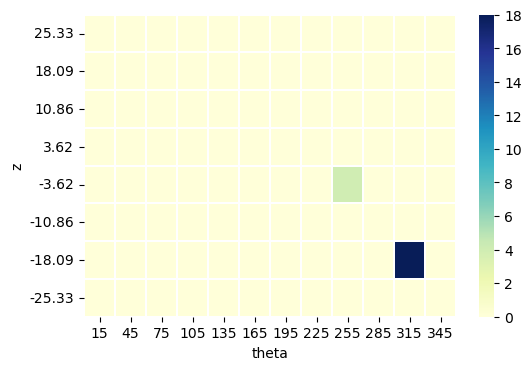

In [7]:
pi_z_theta['Total_Bonds'] = pi_z_theta['TRP_Bonds'] + pi_z_theta['TYR_Bonds'] + pi_z_theta['PHE_Bonds']
pi_z_theta.to_csv('00_MtDARPin_pi.csv')
pi = pd.read_csv('00_MtDARPin_pi.csv')
print(pi_z_theta)

#load csv file
df_wide = pi.pivot_table( index='z', columns='theta', values='Total_Bonds')

hm = sns.heatmap(df_wide, cmap="YlGnBu", linewidths=.003)
hm.invert_yaxis()
hm_fig = hm.get_figure() #this line may be an issue for the cluster, since there are no graphics
hm_fig.savefig("configurations/MtDARPin_pi_test.png")